In [ ]:
# Step 1: Mount Google Drive and unzip CelebA dataset
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')

zip_path ="/content/drive/MyDrive/archive (16).zip"
extract_path = "/content/Dataset/MildDemented"  # Destination folder

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extraction completed!")

Mounted at /content/drive
✅ Extraction completed!


In [ ]:
# Step 2: Generate Blurry Images (Improved Simulation)
import cv2
import numpy as np
import random
from tqdm import tqdm
import os

# Define input/output folders
sharp_folder = os.path.join(extract_path, "Dataset", "MildDemented")
blurry_folder = os.path.join(extract_path, "blurry")

# Create output folder if not exists
os.makedirs(blurry_folder, exist_ok=True)

def apply_motion_blur(image, kernel_size=9):
    """Applies horizontal motion blur"""
    kernel = np.zeros((kernel_size, kernel_size))
    kernel[int((kernel_size - 1)/2), :] = np.ones(kernel_size)
    kernel /= kernel_size
    return cv2.filter2D(image, -1, kernel)

def apply_random_blur(image):
    """Randomly applies Gaussian or Motion blur"""
    blur_type = random.choice(['gaussian', 'motion'])
    if blur_type == 'gaussian':
        return cv2.GaussianBlur(image, (9, 9), sigmaX=random.uniform(0.5, 1.5))
    else:
        return apply_motion_blur(image)

def create_blurry_images(src_folder, dest_folder, limit=8000, img_size=(128, 128)):
    count = 0
    file_list = [f for f in os.listdir(src_folder) if f.endswith(".jpg")]
    random.shuffle(file_list)

    for filename in tqdm(file_list, desc="Creating blurry images"):
        img_path = os.path.join(src_folder, filename)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, img_size)
        blurred = apply_random_blur(img)
        cv2.imwrite(os.path.join(dest_folder, filename), blurred)

        count += 1
        if count >= limit:
            break

# Run the function
create_blurry_images(sharp_folder, blurry_folder)
print("✅ Blurry images created.")

# Get matching pairs
common_files = list(set(os.listdir(blurry_folder)).intersection(set(os.listdir(sharp_folder))))
print(f"🖼️ Total matching image pairs: {len(common_files)}")

Creating blurry images: 100%|██████████| 2000/2000 [00:01<00:00, 1259.29it/s]

✅ Blurry images created.
🖼️ Total matching image pairs: 2000


In [ ]:
# Step 3: Dataset Splitting & Custom Data Generator

# 3.1: Dataset Splitting
from sklearn.model_selection import train_test_split

# Ensure consistent ordering
common_files = sorted(common_files)

# Split into train and validation sets
train_files, val_files = train_test_split(common_files, test_size=0.2, random_state=42)

print(f"📊 Training images: {len(train_files)}")
print(f"📊 Validation images: {len(val_files)}")

# 3.2: Custom Data Generator Class
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

class ImagePairGenerator(Sequence):
    def __init__(self, blurry_dir, sharp_dir, filenames, batch_size=16, img_size=(128, 128), shuffle=True):
        self.blurry_dir = blurry_dir
        self.sharp_dir = sharp_dir
        self.filenames = filenames
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.filenames) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)

    def __getitem__(self, index):
        batch_files = self.filenames[index * self.batch_size:(index + 1) * self.batch_size]
        x_batch, y_batch = [], []

        for file in batch_files:
            try:
                blur_path = os.path.join(self.blurry_dir, file)
                sharp_path = os.path.join(self.sharp_dir, file)

                blur_img = img_to_array(load_img(blur_path, target_size=self.img_size)) / 255.0
                sharp_img = img_to_array(load_img(sharp_path, target_size=self.img_size)) / 255.0

                x_batch.append(blur_img)
                y_batch.append(sharp_img)
            except Exception as e:
                print(f"Error loading {file}: {e}")
                continue

        return np.array(x_batch, dtype=np.float32), np.array(y_batch, dtype=np.float32)

📊 Training images: 1600
📊 Validation images: 400


In [ ]:
# Create training and validation generators
train_gen = ImagePairGenerator(blurry_folder, sharp_folder, train_files, batch_size=16)
val_gen = ImagePairGenerator(blurry_folder, sharp_folder, val_files, batch_size=16)

print("✅ Data generators ready.")

✅ Data generators ready.


In [ ]:
# Step 4: Build Enhanced UNet++ Style Model

# 4.1: Define Conv Block (with BatchNorm + LeakyReLU)
from tensorflow.keras import layers, Model

def conv_block(x, filters, kernel_size=3, dropout_rate=0.0):
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)

    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)

    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
# 4.2: Define UNet++-Inspired Model
def build_advanced_unet(input_shape=(128, 128, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = conv_block(inputs, 32)
    p1 = layers.MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = conv_block(p1, 64)
    p2 = layers.MaxPooling2D(pool_size=(2, 2))(c2)

    c3 = conv_block(p2, 128, dropout_rate=0.3)

    # Decoder
    u2 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c3)
    u2 = layers.concatenate([u2, c2])
    c4 = conv_block(u2, 64)

    u1 = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(c4)
    u1 = layers.concatenate([u1, c1])
    c5 = conv_block(u1, 32)

    outputs = layers.Conv2D(3, kernel_size=1, activation='sigmoid')(c5)

    model = Model(inputs, outputs, name="Enhanced_UNet")
    return model

In [ ]:
# 4.3 Instantiate Model
# Build the model
unet_model = build_advanced_unet((128, 128, 3))
unet_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Enhanced_UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ leaky_re_lu[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ leaky_re_lu_1[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ leaky_re_lu_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ leaky_re_lu_3[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_4[0][0]  

 Total params: 469,155 (1.79 MB)

 Trainable params: 467,875 (1.78 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [ ]:
# Step 5: Define Loss Function and Compile Model

# 5.1: Define SSIM Metric and Combined Loss
import tensorflow as tf

# SSIM as a metric (returns value between -1 and 1, usually around 0–1)
def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

# Combined Loss: 50% MSE + 50% (1 - SSIM)
def combined_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    ssim_val = tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return 0.5 * mse + 0.5 * (1 - ssim_val)

In [ ]:
# 5.2: Compile the Model
from tensorflow.keras.metrics import MeanMetricWrapper

unet_model.compile(
    optimizer='adam',
    loss=combined_loss,
    metrics=[
        'mae',
        MeanMetricWrapper(ssim_metric, name='ssim')
    ]
)

print("✅ Model compiled successfully.")

✅ Model compiled successfully.


In [ ]:
# Step 6: Train the Model (with Callbacks & Generators)

# 6.1: Set Up Callbacks
from tensorflow.keras import callbacks

# Early stopping to halt if validation loss stops improving
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate if val_loss plateaus
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

# Optional: Save best model
checkpoint = callbacks.ModelCheckpoint(
    "/content/enhanced_unet_alz_teacher.h5",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [ ]:
# 6.2: Train the Model
history = unet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.2730 - mae: 0.1753 - ssim: 0.5044
Epoch 1: val_loss improved from inf to 0.33017, saving model to /content/enhanced_unet_alz_teacher.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 84ms/step - loss: 0.2723 - mae: 0.1748 - ssim: 0.5055 - val_loss: 0.3302 - val_mae: 0.1715 - val_ssim: 0.3757 - learning_rate: 0.0010
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0938 - mae: 0.0572 - ssim: 0.8203
Epoch 2: val_loss did not improve from 0.33017
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0936 - mae: 0.0572 - ssim: 0.8207 - val_loss: 0.3331 - val_mae: 0.1726 - val_ssim: 0.3718 - learning_rate: 0.0010
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0537 - mae: 0.0343 - ssim: 0.8955
Epoch 3: val_loss improved from 0.33017 to 0.28358, saving model to /content/enhanced_unet_alz_teacher.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 0.0536 - mae: 0.0343 - ssim: 0.8956 - val_loss: 0.2836 - val_mae: 0.1234 - val_ssim: 0.4526 - learning_rate: 0.0010
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0427 - mae: 0.0298 - ssim: 0.9168
Epoch 4: val_loss improved from 0.28358 to 0.23063, saving model to /content/enhanced_unet_alz_teacher.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 0.0427 - mae: 0.0298 - ssim: 0.9168 - val_loss: 0.2306 - val_mae: 0.0934 - val_ssim: 0.5509 - learning_rate: 0.0010
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0385 - mae: 0.0291 - ssim: 0.9251
Epoch 5: val_loss improved from 0.23063 to 0.14998, saving model to /content/enhanced_unet_alz_teacher.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 0.0385 - mae: 0.0291 - ssim: 0.9251 - val_loss: 0.1500 - val_mae: 0.0497 - val_ssim: 0.7045 - learning_rate: 0.0010
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0374 - mae: 0.0281 - ssim: 0.9273
Epoch 6: val_loss improved from 0.14998 to 0.08024, saving model to /content/enhanced_unet_alz_teacher.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.0374 - mae: 0.0281 - ssim: 0.9273 - val_loss: 0.0802 - val_mae: 0.0327 - val_ssim: 0.8421 - learning_rate: 0.0010
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0360 - mae: 0.0279 - ssim: 0.9299
Epoch 7: val_loss improved from 0.08024 to 0.03041, saving model to /content/enhanced_unet_alz_teacher.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 0.0360 - mae: 0.0279 - ssim: 0.9299 - val_loss: 0.0304 - val_mae: 0.0223 - val_ssim: 0.9406 - learning_rate: 0.0010
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0314 - mae: 0.0263 - ssim: 0.9391
Epoch 8: val_loss did not improve from 0.03041
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 0.0314 - mae: 0.0263 - ssim: 0.9391 - val_loss: 0.0350 - val_mae: 0.0246 - val_ssim: 0.9316 - learning_rate: 0.0010
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0309 - mae: 0.0250 - ssim: 0.9399
Epoch 9: val_loss improved from 0.03041 to 0.02950, saving model to /content/enhanced_unet_alz_teacher.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 0.0309 - mae: 0.0251 - ssim: 0.9399 - val_loss: 0.0295 - val_mae: 0.0226 - val_ssim: 0.9424 - learning_rate: 0.0010
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0286 - mae: 0.0242 - ssim: 0.9443
Epoch 10: val_loss did not improve from 0.02950
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 0.0286 - mae: 0.0242 - ssim: 0.9443 - val_loss: 0.0453 - val_mae: 0.0252 - val_ssim: 0.9111 - learning_rate: 0.0010
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0292 - mae: 0.0247 - ssim: 0.9432
Epoch 11: val_loss improved from 0.02950 to 0.02745, saving model to /content/enhanced_unet_alz_teacher.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 0.0292 - mae: 0.0247 - ssim: 0.9432 - val_loss: 0.0275 - val_mae: 0.0231 - val_ssim: 0.9466 - learning_rate: 0.0010
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0284 - mae: 0.0240 - ssim: 0.9448
Epoch 12: val_loss improved from 0.02745 to 0.02560, saving model to /content/enhanced_unet_alz_teacher.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 0.0284 - mae: 0.0240 - ssim: 0.9448 - val_loss: 0.0256 - val_mae: 0.0214 - val_ssim: 0.9501 - learning_rate: 0.0010
Epoch 13/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0280 - mae: 0.0240 - ssim: 0.9455
Epoch 13: val_loss did not improve from 0.02560
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 0.0280 - mae: 0.0240 - ssim: 0.9456 - val_loss: 0.0273 - val_mae: 0.0224 - val_ssim: 0.9468 - learning_rate: 0.0010
Epoch 14/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0266 - mae: 0.0232 - ssim: 0.9482
Epoch 14: val_loss did not improve from 0.02560
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - loss: 0.0266 - mae: 0.0232 - ssim: 0.9482 - val_loss: 0.0256 - val_mae: 0.0208 - val_ssim: 0.9500 - learning_rate: 0.0010
Epoch 15/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0252 - mae: 0.0226 - ssim: 0.9510
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 15: val_loss did not impro

100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - loss: 0.0241 - mae: 0.0228 - ssim: 0.9532 - val_loss: 0.0249 - val_mae: 0.0192 - val_ssim: 0.9512 - learning_rate: 5.0000e-04
Epoch 18/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0237 - mae: 0.0220 - ssim: 0.9539
Epoch 18: val_loss improved from 0.02493 to 0.02310, saving model to /content/enhanced_unet_alz_teacher.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 0.0237 - mae: 0.0220 - ssim: 0.9539 - val_loss: 0.0231 - val_mae: 0.0184 - val_ssim: 0.9548 - learning_rate: 5.0000e-04
Epoch 19/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0234 - mae: 0.0219 - ssim: 0.9545
Epoch 19: val_loss improved from 0.02310 to 0.02243, saving model to /content/enhanced_unet_alz_teacher.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 0.0234 - mae: 0.0219 - ssim: 0.9545 - val_loss: 0.0224 - val_mae: 0.0195 - val_ssim: 0.9562 - learning_rate: 5.0000e-04
Epoch 20/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0225 - mae: 0.0210 - ssim: 0.9563
Epoch 20: val_loss improved from 0.02243 to 0.02131, saving model to /content/enhanced_unet_alz_teacher.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 0.0225 - mae: 0.0210 - ssim: 0.9562 - val_loss: 0.0213 - val_mae: 0.0179 - val_ssim: 0.9583 - learning_rate: 5.0000e-04
Epoch 21/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0222 - mae: 0.0207 - ssim: 0.9567
Epoch 21: val_loss did not improve from 0.02131
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 0.0222 - mae: 0.0207 - ssim: 0.9567 - val_loss: 0.0217 - val_mae: 0.0211 - val_ssim: 0.9579 - learning_rate: 5.0000e-04
Epoch 22/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0226 - mae: 0.0218 - ssim: 0.9562
Epoch 22: val_loss did not improve from 0.02131
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 0.0226 - mae: 0.0218 - ssim: 0.9562 - val_loss: 0.0383 - val_mae: 0.0197 - val_ssim: 0.9243 - learning_rate: 5.0000e-04
Epoch 23/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0222 - mae: 0.0211 - ssim: 0.9568
Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 23: val_loss d

100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - loss: 0.0207 - mae: 0.0197 - ssim: 0.9598 - val_loss: 0.0201 - val_mae: 0.0174 - val_ssim: 0.9608 - learning_rate: 2.5000e-04
Epoch 26/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0207 - mae: 0.0197 - ssim: 0.9597
Epoch 26: val_loss improved from 0.02007 to 0.01955, saving model to /content/enhanced_unet_alz_teacher.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 0.0207 - mae: 0.0197 - ssim: 0.9597 - val_loss: 0.0196 - val_mae: 0.0171 - val_ssim: 0.9618 - learning_rate: 2.5000e-04
Epoch 27/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0206 - mae: 0.0197 - ssim: 0.9600
Epoch 27: val_loss did not improve from 0.01955
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 0.0206 - mae: 0.0197 - ssim: 0.9600 - val_loss: 0.0196 - val_mae: 0.0172 - val_ssim: 0.9618 - learning_rate: 2.5000e-04
Epoch 28/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0209 - mae: 0.0202 - ssim: 0.9594
Epoch 28: val_loss did not improve from 0.01955
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 0.0209 - mae: 0.0202 - ssim: 0.9594 - val_loss: 0.0206 - val_mae: 0.0175 - val_ssim: 0.9598 - learning_rate: 2.5000e-04
Epoch 29/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0207 - mae: 0.0201 - ssim: 0.9598
Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 29: val_loss di

100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - loss: 0.0207 - mae: 0.0200 - ssim: 0.9597 - val_loss: 0.0186 - val_mae: 0.0168 - val_ssim: 0.9637 - learning_rate: 1.2500e-04
Epoch 31/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0200 - mae: 0.0196 - ssim: 0.9611
Epoch 31: val_loss did not improve from 0.01860
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 0.0200 - mae: 0.0196 - ssim: 0.9611 - val_loss: 0.0191 - val_mae: 0.0167 - val_ssim: 0.9627 - learning_rate: 1.2500e-04
Epoch 32/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0199 - mae: 0.0196 - ssim: 0.9613
Epoch 32: val_loss did not improve from 0.01860
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 0.0199 - mae: 0.0196 - ssim: 0.9613 - val_loss: 0.0234 - val_mae: 0.0172 - val_ssim: 0.9540 - learning_rate: 1.2500e-04
Epoch 33/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0197 - mae: 0.0189 - ssim: 0.9616
Epoch 33: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 33: val_loss di

100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - loss: 0.0196 - mae: 0.0194 - ssim: 0.9618 - val_loss: 0.0185 - val_mae: 0.0166 - val_ssim: 0.9639 - learning_rate: 6.2500e-05
Epoch 36/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0195 - mae: 0.0189 - ssim: 0.9621
Epoch 36: val_loss did not improve from 0.01846
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 0.0195 - mae: 0.0190 - ssim: 0.9621 - val_loss: 0.0190 - val_mae: 0.0167 - val_ssim: 0.9628 - learning_rate: 6.2500e-05
Epoch 37/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0196 - mae: 0.0193 - ssim: 0.9620
Epoch 37: val_loss improved from 0.01846 to 0.01835, saving model to /content/enhanced_unet_alz_teacher.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 0.0196 - mae: 0.0193 - ssim: 0.9619 - val_loss: 0.0183 - val_mae: 0.0166 - val_ssim: 0.9641 - learning_rate: 6.2500e-05
Epoch 38/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0196 - mae: 0.0193 - ssim: 0.9619
Epoch 38: val_loss improved from 0.01835 to 0.01829, saving model to /content/enhanced_unet_alz_teacher.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 0.0196 - mae: 0.0193 - ssim: 0.9619 - val_loss: 0.0183 - val_mae: 0.0162 - val_ssim: 0.9643 - learning_rate: 6.2500e-05
Epoch 39/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0198 - mae: 0.0198 - ssim: 0.9615
Epoch 39: val_loss did not improve from 0.01829
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - loss: 0.0198 - mae: 0.0198 - ssim: 0.9615 - val_loss: 0.0186 - val_mae: 0.0167 - val_ssim: 0.9637 - learning_rate: 6.2500e-05
Epoch 40/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0192 - mae: 0.0187 - ssim: 0.9627
Epoch 40: val_loss improved from 0.01829 to 0.01818, saving model to /content/enhanced_unet_alz_teacher.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 0.0192 - mae: 0.0187 - ssim: 0.9627 - val_loss: 0.0182 - val_mae: 0.0164 - val_ssim: 0.9645 - learning_rate: 6.2500e-05
Epoch 41/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0196 - mae: 0.0190 - ssim: 0.9618
Epoch 41: val_loss improved from 0.01818 to 0.01805, saving model to /content/enhanced_unet_alz_teacher.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 0.0196 - mae: 0.0190 - ssim: 0.9618 - val_loss: 0.0180 - val_mae: 0.0163 - val_ssim: 0.9647 - learning_rate: 6.2500e-05
Epoch 42/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0196 - mae: 0.0194 - ssim: 0.9618
Epoch 42: val_loss improved from 0.01805 to 0.01804, saving model to /content/enhanced_unet_alz_teacher.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - loss: 0.0196 - mae: 0.0194 - ssim: 0.9618 - val_loss: 0.0180 - val_mae: 0.0163 - val_ssim: 0.9647 - learning_rate: 6.2500e-05
Epoch 43/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0192 - mae: 0.0185 - ssim: 0.9626
Epoch 43: val_loss did not improve from 0.01804
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 0.0192 - mae: 0.0185 - ssim: 0.9626 - val_loss: 0.0181 - val_mae: 0.0164 - val_ssim: 0.9646 - learning_rate: 6.2500e-05
Epoch 44/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0190 - mae: 0.0184 - ssim: 0.9629
Epoch 44: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 44: val_loss did not improve from 0.01804
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 0.0190 - mae: 0.0185 - ssim: 0.9629 - val_loss: 0.0180 - val_mae: 0.0166 - val_ssim: 0.9648 - learning_rate: 6.2500e-05
Epoch 45/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0192 - mae: 0.0193 - ssim: 0.9627
Epoch 45: val_loss d

100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - loss: 0.0190 - mae: 0.0189 - ssim: 0.9630 - val_loss: 0.0179 - val_mae: 0.0162 - val_ssim: 0.9650 - learning_rate: 3.1250e-05
Epoch 47/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0195 - mae: 0.0192 - ssim: 0.9620
Epoch 47: val_loss did not improve from 0.01791
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - loss: 0.0195 - mae: 0.0192 - ssim: 0.9620 - val_loss: 0.0183 - val_mae: 0.0165 - val_ssim: 0.9643 - learning_rate: 3.1250e-05
Epoch 48/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0193 - mae: 0.0188 - ssim: 0.9624
Epoch 48: val_loss did not improve from 0.01791
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - loss: 0.0193 - mae: 0.0188 - ssim: 0.9624 - val_loss: 0.0179 - val_mae: 0.0162 - val_ssim: 0.9650 - learning_rate: 3.1250e-05
Epoch 49/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0191 - mae: 0.0186 - ssim: 0.9628
Epoch 49: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 49: val_loss

100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.0191 - mae: 0.0186 - ssim: 0.9628 - val_loss: 0.0179 - val_mae: 0.0163 - val_ssim: 0.9651 - learning_rate: 3.1250e-05
Epoch 50/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0190 - mae: 0.0184 - ssim: 0.9629
Epoch 50: val_loss improved from 0.01787 to 0.01785, saving model to /content/enhanced_unet_alz_teacher.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - loss: 0.0190 - mae: 0.0184 - ssim: 0.9629 - val_loss: 0.0179 - val_mae: 0.0163 - val_ssim: 0.9651 - learning_rate: 1.5625e-05
Restoring model weights from the end of the best epoch: 50.


In [ ]:
import os
folder_path = "/content/drive/MyDrive/TeacherModelalz"
os.makedirs(folder_path, exist_ok=True)


In [ ]:
# Save model to Google Drive after training
unet_model.save("/content/drive/MyDrive/TeacherModelalz/teacher_unet_alz.h5")
print("✅ Teacher model saved to Drive!")

✅ Teacher model saved to Drive!


In [ ]:
print(os.path.exists("/content/drive/MyDrive/TeacherModel2/teacher_unet_alz.h5"))  # Should return True

False


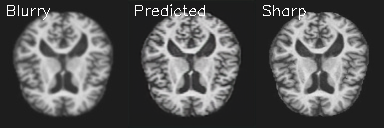

In [ ]:
# Step 7: Visualize Predictions from the Enhanced Model

# 7.1: Visualize a Single Prediction
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Choose a sample image file from the validation set
sample_filename = val_files[0]

# Construct paths
blurry_path = os.path.join(blurry_folder, sample_filename)
sharp_path = os.path.join(sharp_folder, sample_filename)

# Load and resize images
blurry_img = cv2.imread(blurry_path)
sharp_img = cv2.imread(sharp_path)

# Check if both images are loaded correctly
if blurry_img is None or sharp_img is None:
    print("One or both images could not be loaded.")
else:
    blurry_resized = cv2.resize(blurry_img, (128, 128))
    sharp_resized = cv2.resize(sharp_img, (128, 128))

    # Normalize and prepare for prediction
    input_img = np.expand_dims(blurry_resized.astype("float32") / 255.0, axis=0)
    prediction = unet_model.predict(input_img, verbose=0)
    predicted_img = (prediction[0] * 255).astype("uint8")

    # Add labels
    labeled_blur = cv2.putText(blurry_resized.copy(), "Blurry", (5, 15),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
    labeled_pred = cv2.putText(predicted_img.copy(), "Predicted", (5, 15),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
    labeled_sharp = cv2.putText(sharp_resized.copy(), "Sharp", (5, 15),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)

    # Concatenate images
    combined = np.hstack([labeled_blur, labeled_pred, labeled_sharp])
    cv2_imshow(combined)

In [ ]:
# Step 8: Evaluate Model Performance on Test Batches
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf

def evaluate_ssim_mae(model, data_gen, num_batches=10):
    total_ssim = 0.0
    total_mae = 0.0
    count = 0

    for batch_index in range(num_batches):
        x_batch, y_batch = data_gen[batch_index]
        preds = model.predict(x_batch, verbose=0)

        for pred_img, true_img in zip(preds, y_batch):
            pred_gray = tf.image.rgb_to_grayscale(pred_img).numpy().squeeze()
            true_gray = tf.image.rgb_to_grayscale(true_img).numpy().squeeze()

            # Calculate SSIM
            ssim_score = ssim(pred_gray, true_gray, data_range=1.0)
            total_ssim += ssim_score

            # Calculate MAE
            mae_score = np.mean(np.abs(pred_img - true_img))
            total_mae += mae_score

            count += 1

    avg_ssim = total_ssim / count if count else 0
    avg_mae = total_mae / count if count else 0
    return avg_ssim, avg_mae

# Run evaluation
avg_ssim, avg_mae = evaluate_ssim_mae(unet_model, val_gen, num_batches=10)
print(f"📈 Average SSIM: {avg_ssim:.4f}")
print(f"📉 Average MAE : {avg_mae:.4f}")

📈 Average SSIM: 0.9711
📉 Average MAE : 0.0165


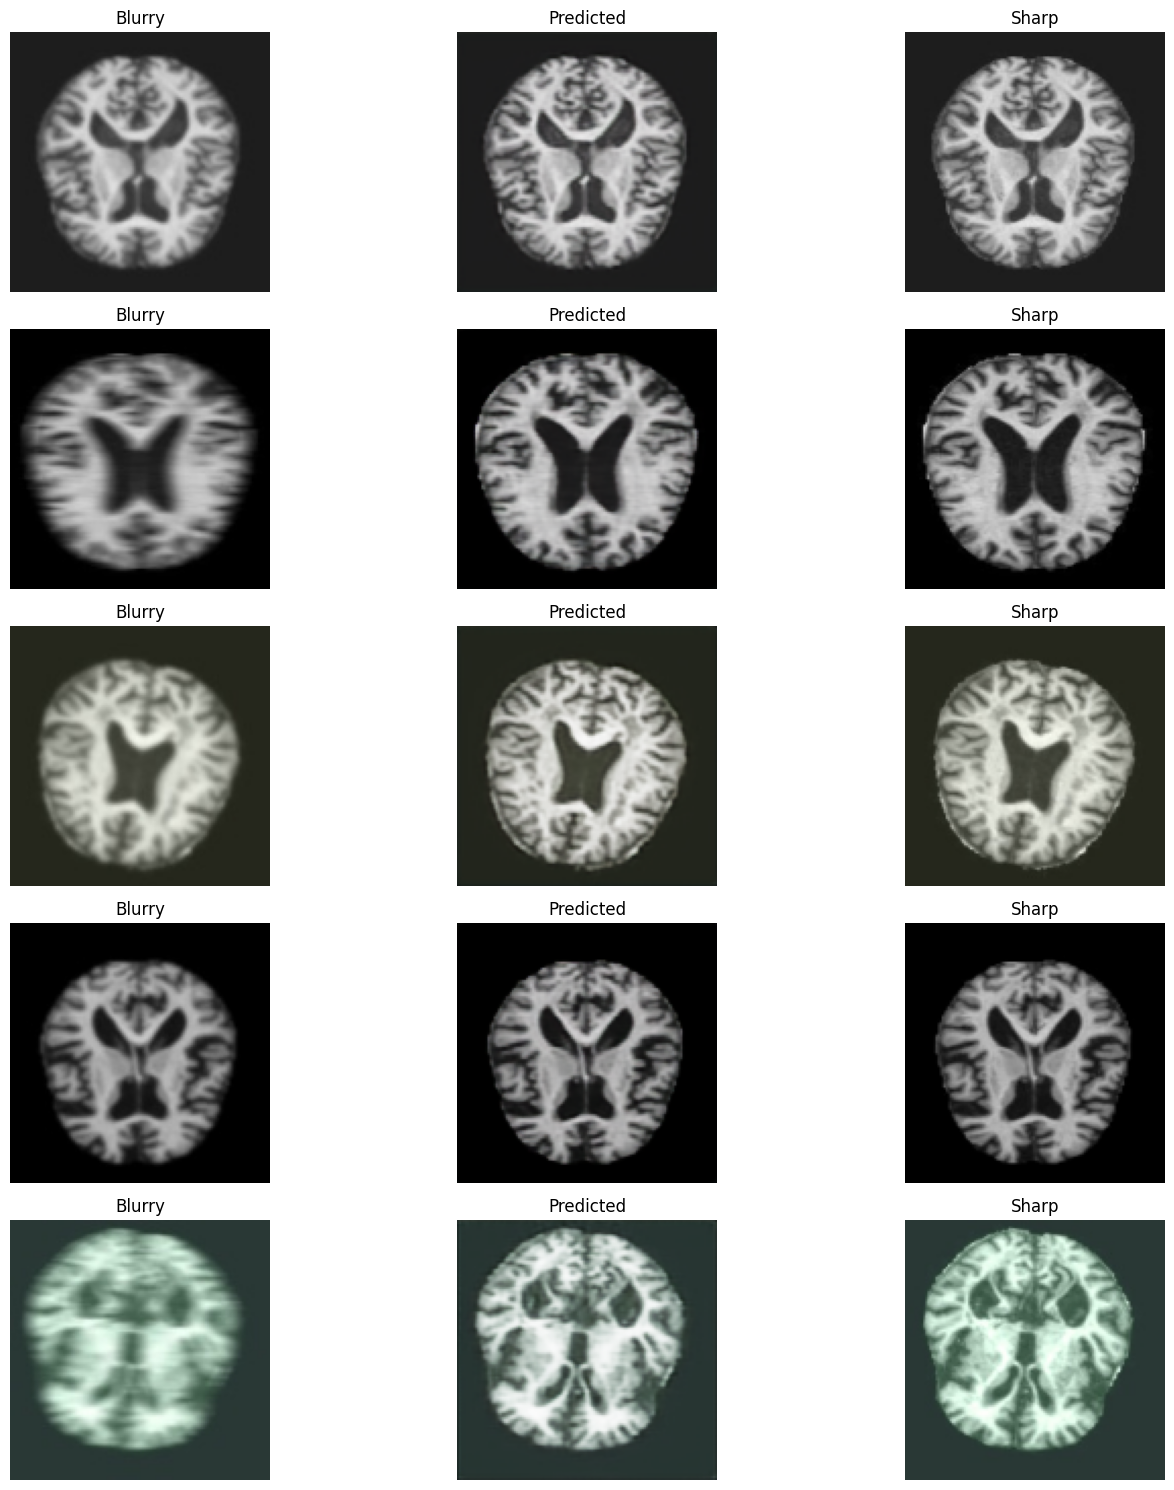

In [ ]:
import matplotlib.pyplot as plt

def visualize_multiple_predictions(model, data_gen, sample_indices=[0, 1, 2, 3, 4]):
    plt.figure(figsize=(15, len(sample_indices) * 3))

    for i, idx in enumerate(sample_indices):
        filename = val_files[idx]
        blur_path = os.path.join(blurry_folder, filename)
        sharp_path = os.path.join(sharp_folder, filename)

        # Read and resize
        blur = cv2.imread(blur_path)
        sharp = cv2.imread(sharp_path)

        if blur is None or sharp is None:
            print(f"Error loading image: {filename}")
            continue

        blur = cv2.resize(blur, (128, 128))
        sharp = cv2.resize(sharp, (128, 128))

        # Predict
        input_img = np.expand_dims(blur.astype("float32") / 255.0, axis=0)
        prediction = model.predict(input_img, verbose=0)[0]
        prediction = (prediction * 255).astype("uint8")

        # Plot
        plt.subplot(len(sample_indices), 3, i * 3 + 1)
        plt.imshow(cv2.cvtColor(blur, cv2.COLOR_BGR2RGB))
        plt.title("Blurry")
        plt.axis('off')

        plt.subplot(len(sample_indices), 3, i * 3 + 2)
        plt.imshow(cv2.cvtColor(prediction, cv2.COLOR_BGR2RGB))
        plt.title("Predicted")
        plt.axis('off')

        plt.subplot(len(sample_indices), 3, i * 3 + 3)
        plt.imshow(cv2.cvtColor(sharp, cv2.COLOR_BGR2RGB))
        plt.title("Sharp")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display predictions for 5 validation images
visualize_multiple_predictions(unet_model, val_gen, sample_indices=[0, 10, 20, 30, 40])